In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score
from scipy.stats import pearsonr, spearmanr
import torch
from dm_functions_figqa import *
import dm_functions_figqa
import statistics
import pickle
from nltk.stem import WordNetLemmatizer
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

C:\Users\jo16726\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load Datasets

In [4]:
# load dataset
#data_long = pd.read_csv('Datasets/Fig-QA Dataset Copy.csv')
#data_lem = pd.read_csv('Datasets/figqa_lemmatised.csv')
data_pca = pd.read_csv('Datasets/Fig-QA Dataset for PCA Copy.csv')
data_test = pd.read_excel('Datasets/figqa test labels.xlsx')

data = data_pca
data = data[(data.labels!=-1)]
dataname = "long"

# Import embeddings

In [7]:
glove = import_embeddings('../trained_dms_txt/baselines/glove_trained.txt',matrix=False)
#Models/

from models import InferSent
model_version = 2
MODEL_PATH = "encoder/infersent%s.pkl" % model_version
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}
InfersentFasttext = InferSent(params_model)
InfersentFasttext.load_state_dict(torch.load(MODEL_PATH))

VEC_PATH = 'trained_dms_txt/baselines/fasttext-crawl-300d-2M.vec'
InfersentFasttext.set_w2v_path(VEC_PATH)

sentences1 = [sent for sent in data.loc[:,'startphrase']]
sentences2 = [sent for sent in data.loc[:,'ending1']]
sentences3 = [sent for sent in data.loc[:,'ending2']]

sentences = sentences1 + sentences2 + sentences3
InfersentFasttext.build_vocab(sentences)

In [8]:
SBERTall = SentenceTransformer('all-MiniLM-L6-v2')

In [9]:
SBERT2 = SentenceTransformer('all-mpnet-base-v2')

In [10]:
import warnings
warnings.filterwarnings(action='ignore')


In [12]:
# Prepare SBERT embeddings for PCA

#models = (("sbertall", SBERTall),("sbert2", SBERT2))
# "name for output", model object
#for model, MODEL in models:

sentences = 'ending'
#sentences = 'startphrase'

model = "sbertall"
MODEL = SBERTall
dim = len(MODEL.encode('test'))
s_embeddings = []
labels = []
for i, row in data.iterrows():
    try:
        embedding = MODEL.encode(row[sentences])
        neg_label = 'notintens' if row['intensification'] == 'not' else row['negation']
        labels.append([row['startphrase'],row['ending'],row['xid'],row['simile'],neg_label,row['intensification'],row['negation all']])
        s_embeddings.append([row['xid']]+list(embedding))
    except KeyError:
        s_embeddings.append(None)

labelcolumns = ['startphrase', 'ending', 'xid', 'simile', 'negation', 'intensification', 'negation all']
embeddingcolumns = ['d' + str(d) for d in range(dim)]
embeddingdata = pd.DataFrame(s_embeddings, columns = ['xid']+embeddingcolumns)
labeldata = pd.DataFrame(labels, columns = labelcolumns)

labeldata.to_csv('labeldata.csv')

#    sdata['cos1 {}'.format(model+"_"+dataname)], sdata['cos2 {}'.format(model+"_"+dataname)] = cos_scores1, cos_scores2
#    sdata['cos_posneg {}'.format(model+"_"+dataname)] = cos_scores_posneg
#    sdata['bin {}'.format(model+"_"+dataname)] = classifications


In [13]:
labeldata = pd.read_csv('labeldata.csv').drop('Unnamed: 0', axis=1)
labeldata.fillna('none', inplace=True)

In [14]:
# Run PCA
pca = PCA()
pc = pca.fit_transform(embeddingdata.drop('xid', axis=1))
pcdata = pd.DataFrame(pc) #, columns = ['pc1', 'pc2']
pcdata['xid'] = embeddingdata['xid']
#pca.explained_variance_ratio_

<function matplotlib.pyplot.show(close=None, block=None)>

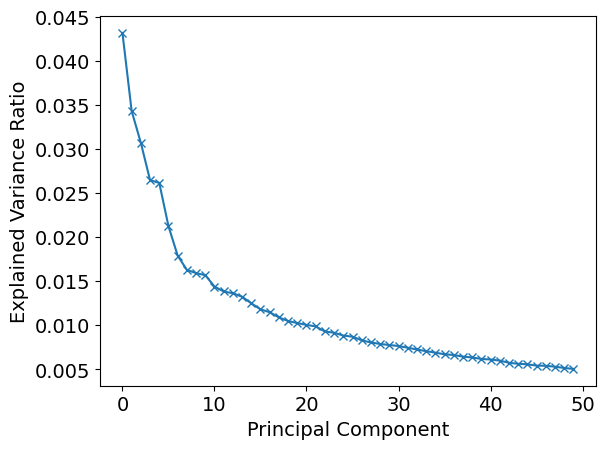

In [15]:
evr = pd.DataFrame(pca.explained_variance_ratio_[:50])
plt.rcParams.update({'font.size': 14})
plt.plot(evr, marker='x')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component')

plt.show

In [16]:
def plot_pca(pcx,pcy,legend=True,groups='n'):
    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize=(10,10))
    plt.xticks()
    plt.yticks()
    plt.xlabel('Principal Component {}'.format(pcx))
    plt.ylabel('Principal Component {}'.format(pcy))
    
    if groups == 'a': #negall - grammatical negation of all paraphrases
        targets = ['aff', 'neg']
        labels = ['aff', 'neg']
        colours = ['b', 'r']
        searchcolumn = 'negation all'
        
    elif groups == 'n': #posneg -intens/neg(for simile paraphrases)/other
        targets = ['none', 'notintens', 'not']
        labels = ['other', '"not" neg', '"not" intens']
        colours = ['g', 'r', 'b']
        searchcolumn = 'negation'
        
    elif groups == 'c': #correct (model classified correctly or not)
        targets = ['y', 'n']
        labels = ['correct', 'incorrect']
        colours = ['b', 'r']
        searchcolumn = 'correct'
        
        
    for target, colour in zip(targets,colours):
        indicesToKeep = labeldata[searchcolumn] == target
        plt.scatter(pcdata.loc[indicesToKeep, pcx],
                    pcdata.loc[indicesToKeep, pcy], c = colour, s = 10)

    if legend == True:
        plt.legend(labels, markerscale=3)

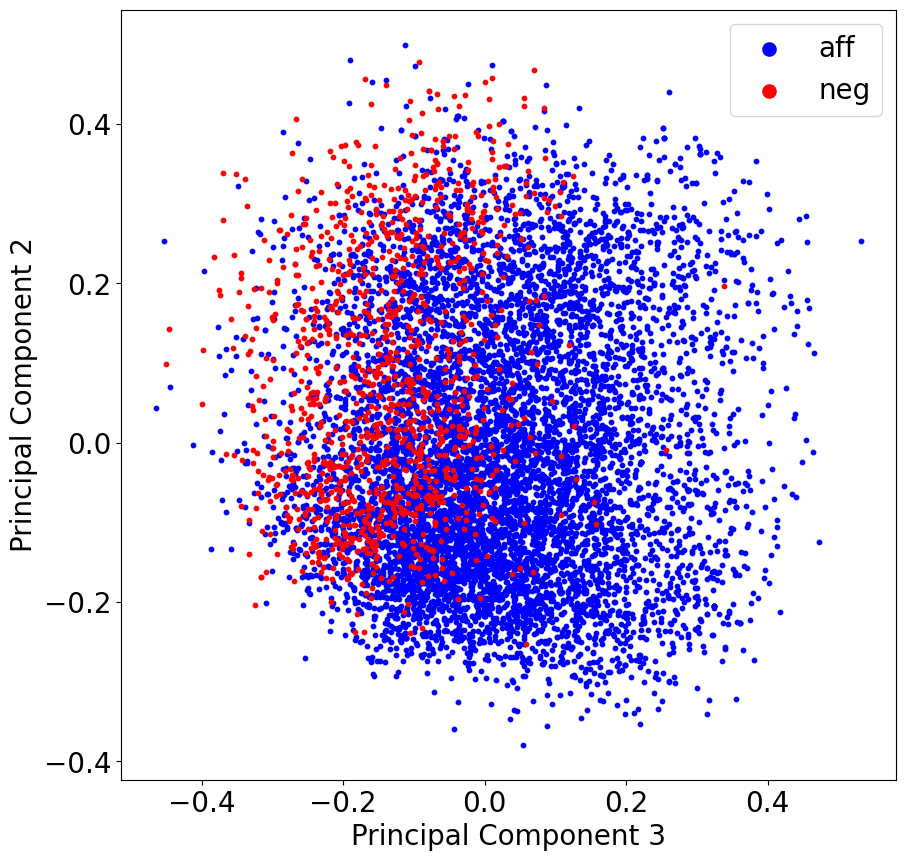

In [17]:
plot_pca(3,2,groups='a')

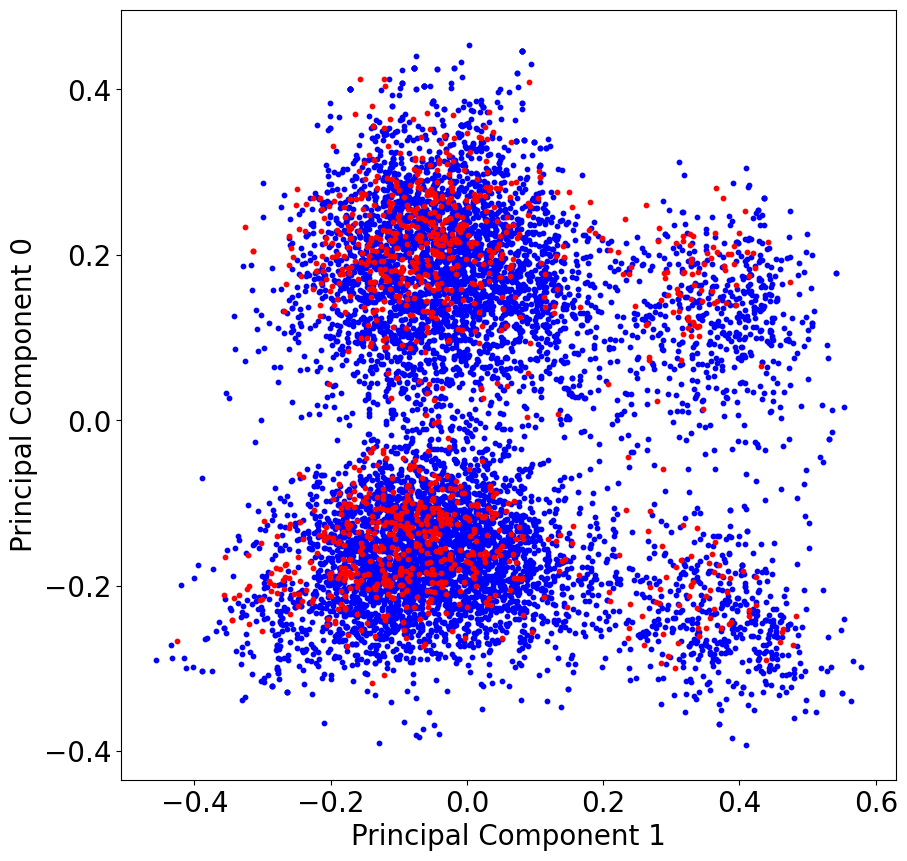

In [18]:
plot_pca(1,0,legend=False,groups='a')

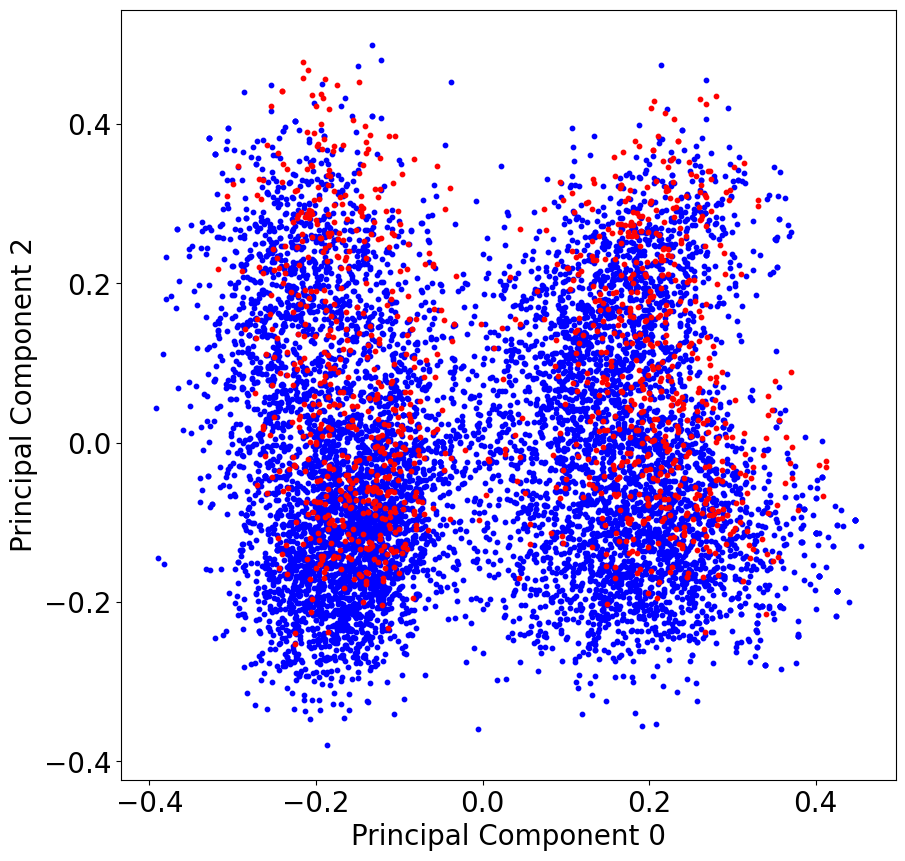

In [19]:
plot_pca(0,2,legend=False,groups='a')

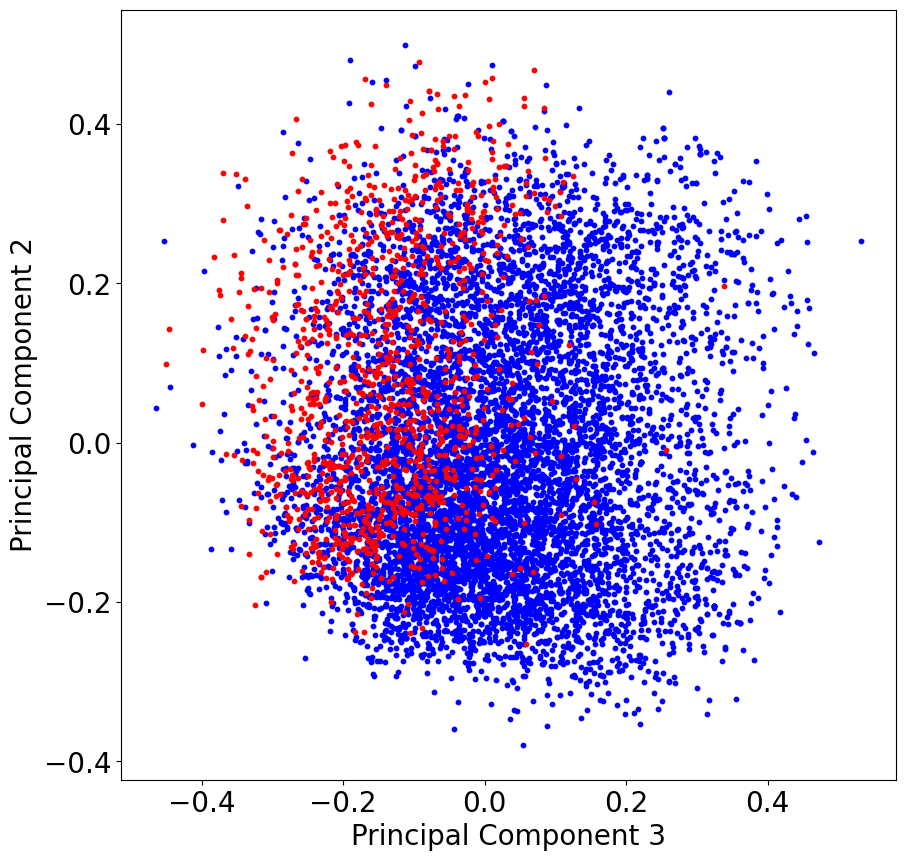

In [20]:
plot_pca(3,2,legend=False,groups='a')

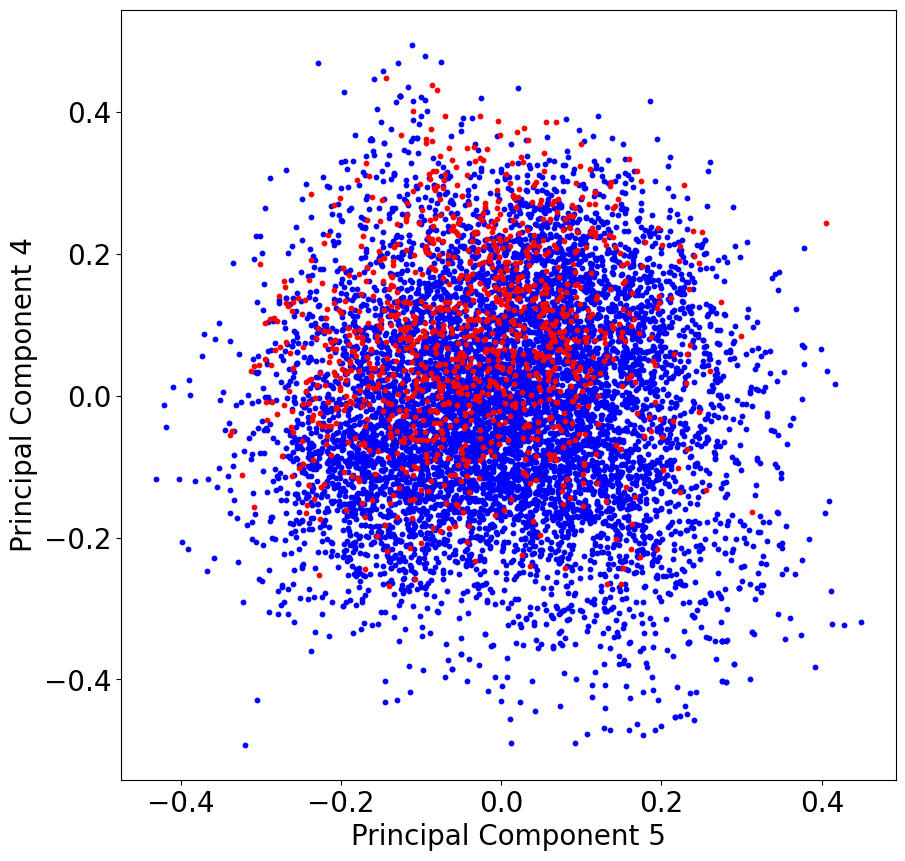

In [21]:
plot_pca(5,4,legend=False,groups='a')

"    \nfor ax1 in range(10):\n    for ax2 in range(10):\n        axs[ax1, ax2].set(xlabel='PC-{}'.format(ax1), ylabel='PC-{}'.format(ax2))\n        axs[ax1, ax2].label_outer()\n        \n        \n#plt.savefig('.png')\n       # axs[ax1, ax2].scatter(pcdata.loc[indicesToKeep, ax1],\n       #         pcdata.loc[indicesToKeep, ax2], c = colour, s = 3)\n"

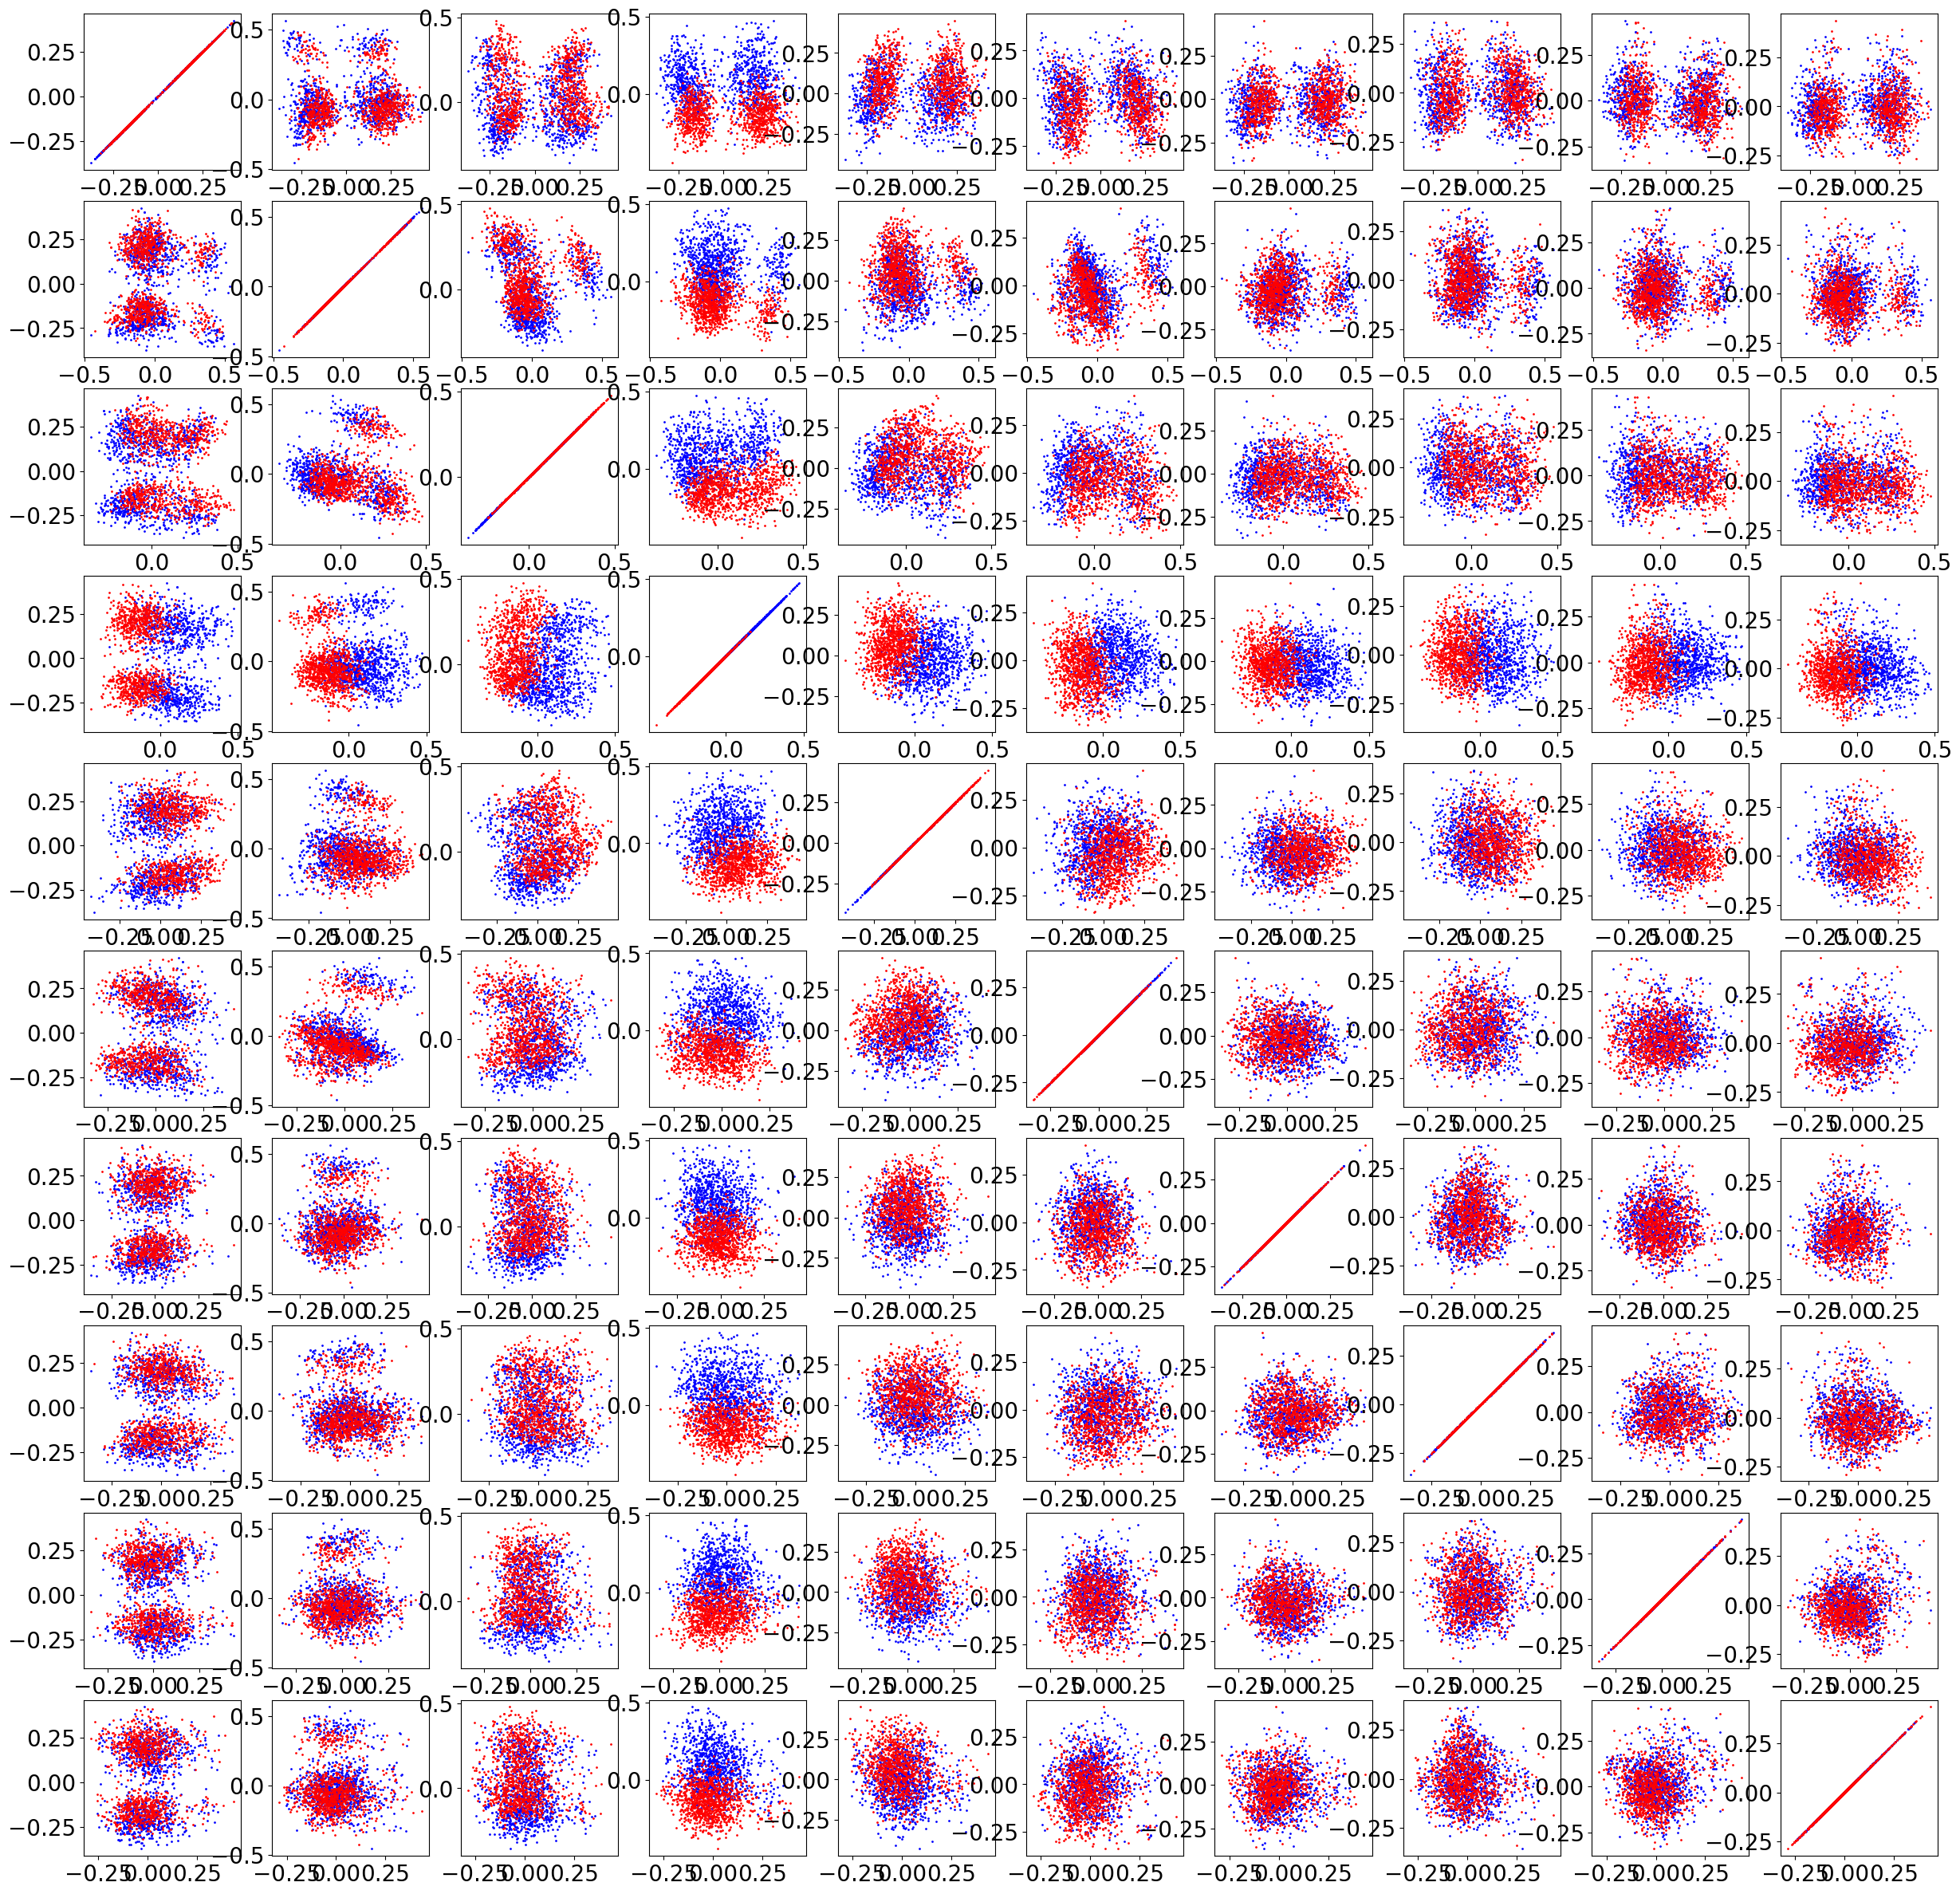

In [22]:

fig, axs = plt.subplots(10, 10, figsize=(30,30))
for ax1 in range(10):
    for ax2 in range(10):
        targets = ['none', 'notintens', 'not']
        colours = ['g', 'b', 'r']
        for target, colour in zip(targets,colours):
            indicesToKeep = labeldata['negation'] == target
            axs[ax1, ax2].scatter(pcdata.loc[indicesToKeep, ax1+0],
                                  pcdata.loc[indicesToKeep, ax2+0], c = colour, s = 1)

    
'''    
for ax1 in range(10):
    for ax2 in range(10):
        axs[ax1, ax2].set(xlabel='PC-{}'.format(ax1), ylabel='PC-{}'.format(ax2))
        axs[ax1, ax2].label_outer()
        
        
#plt.savefig('.png')
       # axs[ax1, ax2].scatter(pcdata.loc[indicesToKeep, ax1],
       #         pcdata.loc[indicesToKeep, ax2], c = colour, s = 3)
'''     

In [87]:
# create lists of ids of instances with certain pc values
lists = {}
lists['all'] = pcdata['xid']
for pc in range(27):
    lists['{}l'.format(pc)] = pcdata.nsmallest(int(0.1*len(pcdata)),pc)['xid']
    lists['{}h'.format(pc)] = pcdata.nlargest(int(0.1*len(pcdata)),pc)['xid']
    
lists_l = {}
lists_h = {}
list_all = {'all': pcdata['xid']}
for pc in range(27):
    lists_l['{}'.format(pc)] = pcdata.nsmallest(int(0.1*len(pcdata)),pc)['xid']
    lists_h['{}'.format(pc)] = pcdata.nlargest(int(0.1*len(pcdata)),pc)['xid']

negation proportions in pca splits

In [88]:
# calculate neg proportions of splits and save - output table

results = pd.DataFrame({'all':[None]*len(lists_l),
                        'l':[None]*len(lists_l),
                        'h':[None]*len(lists_l),
                        }, index=lists_l.keys())

subdata = data[data['xid'].isin(list_all['all'])]
results.at['0','all'] = len(subdata[subdata["not all"]=='TRUE'])/len(subdata)

for lists_lh, resultcolumn in (lists_l, 'l'), (lists_h, 'h'):
    for splitname in lists_l.keys():
        subdata = data[data['xid'].isin(lists_lh[splitname])]
        results.at[splitname, resultcolumn] = len(subdata[subdata["not all"]=='TRUE'])/len(subdata)

results.to_csv('Results all Nov24/pca_negproportions-all_{}.csv'.format(model))

accuracies of pca splits

In [89]:
# calculate accuracies of splits and save (SBERTall)
cosdata = pd.read_excel('results all Nov24/test_model_all_summary.xlsx', sheet_name = 'test_output')
pca_results = {}
for splitname in lists.keys():
    subdata = cosdata[cosdata['xid'].isin(lists[splitname])]
    pca_results[splitname] = np.mean(subdata['bin sbertall_long'])
pd.DataFrame(pca_results.values(), index=pca_results.keys(), columns = [model]).to_csv('Results all Nov24/pca_accuracies_full_{}.csv'.format(model))

In [90]:
# calculate accuracies of splits and save (SBERTall negpairs)
cosdata = pd.read_excel('results all Nov24/test_model_all_summary.xlsx', sheet_name = 'test_output')
pca_results = {}
for splitname in lists.keys():
    subdata = cosdata[cosdata['xid'].isin(lists[splitname])]
    subsubdata = subdata[subdata['neg pairs']==1]
    pca_results[splitname] = np.mean(subsubdata['bin sbertall_long'])
pd.DataFrame(pca_results.values(), index=pca_results.keys(), columns = [model]).to_csv('Results all Nov24/pca_accuracies_negpairs_{}.csv'.format(model))

concreteness proportions of pca splits

In [91]:
# calculate concreteness proportions of splits and save - output table
cosdata = pd.read_csv('Datasets/Fig-QA parsed.csv')

results = pd.DataFrame({'all':[None]*len(lists_l),
                        'l':[None]*len(lists_l),
                        'h':[None]*len(lists_l),
                        }, index=lists_l.keys())

subdata = cosdata[cosdata['xid'].isin(list_all['all'])]
results.at['0','all'] = np.mean(subdata['concreteness'])

for lists_lh, resultcolumn in (lists_l, 'l'), (lists_h, 'h'):   
    for splitname in lists_l.keys():
        subdata = cosdata[cosdata['xid'].isin(lists_lh[splitname])]
        results.at[splitname, resultcolumn] = np.mean(subdata['concreteness'])
    
results.to_csv('Results all Nov24/pca_concproportions-all_{}.csv'.format(model))

recalculation of original accuracies

In [61]:
# calculate accuracies (negpairs) and save
cosdata = pd.read_excel('FIG-QA/costest results v2.xlsx', sheet_name = 'bin lemma')
results = {}
mlist = ['cos1 sbert','cos1 sbert2','cos1 infersent1','cos1 infersent2','cos1 glove add','cos1 glove mult','cos1 w2v add','cos1 w2v mult','cos1 ms-word2dm-c5 add','cos1 ms-word2dm-c5 mult','cos1 ms-word2dm-c10 add','cos1 ms-word2dm-c10 mult','cos1 ms-word2dm-d5 add','cos1 ms-word2dm-d5 mult','cos1 ms-word2dm-d10 add','cos1 ms-word2dm-d10 mult']
subdata = cosdata[cosdata['negpairs']==1]
for m in mlist:
    results[m] = np.mean(subdata[m])
pd.DataFrame(results.values(), index=results.keys(), columns = ['negpairs']).to_csv('FIG-QA/accuracies_lem_negpairs.csv'.format(model))

In [62]:
# calculate accuracies (not negpairs) and save
cosdata = pd.read_excel('FIG-QA/costest results v2.xlsx', sheet_name = 'bin lemma')
results = {}
mlist = ['cos1 sbert','cos1 sbert2','cos1 infersent1','cos1 infersent2','cos1 glove add','cos1 glove mult','cos1 w2v add','cos1 w2v mult','cos1 ms-word2dm-c5 add','cos1 ms-word2dm-c5 mult','cos1 ms-word2dm-c10 add','cos1 ms-word2dm-c10 mult','cos1 ms-word2dm-d5 add','cos1 ms-word2dm-d5 mult','cos1 ms-word2dm-d10 add','cos1 ms-word2dm-d10 mult']
subdata = cosdata[cosdata['simile']==1]
subsubdata = subdata[subdata['negpairs']!=1]
for m in mlist:
    results[m] = np.mean(subsubdata[m])
pd.DataFrame(results.values(), index=results.keys(), columns = ['not negpairs']).to_csv('FIG-QA/accuracies_lem_notnegpairs.csv'.format(model))

In [63]:
# calculate accuracies (negpairs) (LLM)) and save
cosdata = pd.read_excel('FIG-QA/test_LLM.xlsx', sheet_name = 'test_LLM')
results = {}
mlist = ['GPT-Neo-1.3B bin','Llama-2 7B bin']
subdata = cosdata[cosdata['negpairs']==1]
for m in mlist:
    results[m] = np.mean(subdata[m])
pd.DataFrame(results.values(), index=results.keys(), columns = ['negpairs']).to_csv('FIG-QA/accuraciesLLM_lem_negpairs.csv'.format(model))

In [64]:
# calculate accuracies (not negpairs) (LLM) and save
cosdata = pd.read_excel('FIG-QA/test_LLM.xlsx', sheet_name = 'test_LLM')
results = {}
mlist = ['GPT-Neo-1.3B bin','Llama-2 7B bin']
subdata = cosdata[cosdata['sim']==1]
subsubdata = subdata[subdata['negpairs']!=1]
for m in mlist:
    results[m] = np.mean(subsubdata[m])
pd.DataFrame(results.values(), index=results.keys(), columns = ['not negpairs']).to_csv('FIG-QA/accuraciesLLM_lem_notnegpairs.csv'.format(model))

accuracy with concreteness score

In [10]:
# Build id lists of high and low concreteness
cosdata = pd.read_csv('Datasets/Fig-QA parsed.csv')
cosdata = cosdata[cosdata['labels']==-1]
c_lists = {}
c_lists['all'] = cosdata['xid']
c_lists['l'] = cosdata.nsmallest(int(0.1*len(cosdata)),'concreteness')['xid']
c_lists['h'] = cosdata.nlargest(int(0.1*len(cosdata)),'concreteness')['xid']

In [11]:
# Save lists
pd.DataFrame(c_lists).to_csv('Datasets/concreteness_category_lists_test.csv')